In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from filtering import kalman_filter, weighted_avg_filter

In [74]:
# Threshold in mm distance
def clustering_algorithm(measurements, threshold = 15):
    clusters: list[list[tuple(float, float)]] = []

    for x,y in measurements:
        for cluster in clusters:
            x_candidate, y_candidate = np.mean(cluster, axis=0)
            if np.sqrt((x - x_candidate) ** 2 + (y - y_candidate) ** 2) < threshold:
                # print("Distance: ", np.sqrt((x - x_candidate) ** 2 + (y - y_candidate) ** 2))
                cluster.append((x,y))
                break
        else:
            clusters.append([(x,y)])

    winning_cluster = max(clusters, key=len)
    x_pos = np.mean(winning_cluster, axis=0)[0]
    y_pos = np.mean(winning_cluster, axis=0)[1]
    return x_pos, y_pos, winning_cluster, clusters

# test_data = [(5.136475959207072, -29.639914965294167), (-39.981975884233165, -14.698455516239752), (3.032786613043486, -28.91572808119642), (-42.67661558210149, 43.24547096112046), (1.2885113251843295e-13, -1.7165323606573238e-12), (5.227245842587954, -27.58314228372666), (-103.94094517700948, -25.67596032802457)]
# x_pos, y_pos, winning_cluster, clusters = clustering_algorithm(test_data)
# print(x_pos, y_pos)

In [75]:
speed = 0.343 # mm / us
radius_mm = 220/2

def functions(x0, y0, x1, y1, x2, y2, d01, d02, d12):
    """ Given observers at (x0, y0), (x1, y1), (x2, y2) and TDOA between observers d01, d02, d12, this closure
        returns a function that evaluates the system of three hyperbolae for given event x, y.
    """
    def fn(args):
        x, y = args
        a = np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d01
        b = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d02
        c = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - d12
        return a**2 + b**2 + c**2
    return fn

def solve_3_points(measurement0, measurement1, measurement2):
    x0, y0, t0 = measurement0
    x1, y1, t1 = measurement1
    x2, y2, t2 = measurement2
    xp = np.mean([x0, x1, x2])
    yp = np.mean([y0, y1, y2])
    F = functions(x0, y0, x1, y1, x2, y2, (t1 - t0) * speed, (t2 - t0) * speed, (t2 - t1) * speed)
    res = opt.least_squares(F, [xp, yp])
    x, y = res.x
    # print("Cost: ", res.cost)
    return x, y, res.cost

def check_sol_validity(measurement0, measurement1, measurement2):
    solx, soly, cost = solve_3_points(measurement0, measurement1, measurement2)
    valid = False
    if (solx ** 2 + soly ** 2 < radius_mm ** 2 and cost < 1e-3):
        valid = True
    return [solx, soly, measurement0, measurement1, measurement2, valid]

def solve_best_fit(measurements, threshold):
    index_lut = [[0,1,2], [0,1,3], [0,1,4], [0,2,3], [0,2,4], [0,3,4], [1,2,3], [1,2,4], [1,3,4], [2,3,4]]
    sols = []

    for indexes in index_lut:
        # print("mics used: ", indexes)
        results = check_sol_validity(measurements[indexes[0]], measurements[indexes[1]], measurements[indexes[2]])
        # print("position: ", results[0], results[1], results[-1])
        if results[-1]:
            sols.append(results)
    if len(sols) > 0:
        x = [x[0] for x in sols]
        y = [x[1] for x in sols]
        # print(f"Average: ({np.mean(x)}, {np.mean(y)})")
        valid_points = [(sol[0], sol[1]) for sol in sols if sol[-1]]
        cluster_x, cluster_y, winning_cluster, clusters = clustering_algorithm(valid_points, threshold)
        # acceptable_clusters = [cluster for cluster in clusters if len(cluster) > 0]
        # for cluster in acceptable_clusters:
        #     cluster_x, cluster_y = np.mean(cluster, axis=0)
        # # print("Cluster results: ", cluster_x, cluster_y)
        figure, axes = plt.subplots()
        field = plt.Circle((0, 0), radius_mm, color='lightgreen')
        cluster = plt.Circle((cluster_x, cluster_y), threshold, fill = False, color='r')
        axes.set_aspect(1)
        axes.add_artist(field) 
        plt.plot(x, y, 'bo')
        axes.add_artist(cluster)
        plt.xlim([-radius_mm-10, radius_mm+10])
        plt.ylim([-radius_mm-10, radius_mm+10])
        plt.show()
        print("Cluster: ", cluster_x, cluster_y, " Len: ", len(winning_cluster))
        return cluster_x, cluster_y, np.std(winning_cluster, axis=0)
    else:
        print("No valid solution")
        return None, None, None

    
    # cluster_lens = [len(cluster) for cluster in clusters]
    # print("Len of clusters: ", cluster_lens)

    # acceptable_clusters = [cluster for cluster in clusters if len(cluster) > 0]
    # for cluster in acceptable_clusters:
    #     cluster_x, cluster_y = np.mean(cluster, axis=0)
    #     print("Cluster: ", cluster_x, cluster_y, " Len: ", len(cluster))
    # # print("Cluster results: ", cluster_x, cluster_y)
    # print("")

    # meanx = np.mean(validx)
    # meany = np.mean(validy)
    # print("Means: ", meanx, meany)
    # valid_pos = [(x,y) for x,y in zip(validx, validy)]
    # print("Valid positions: ", valid_pos)
    # print("Std: ", np.std(validx), np.std(validy))
    # print("Winning cluster len: ", len(winning_cluster))
    # print("Cluster results: ", cluster_x, cluster_y)
    # print("")
    # return ret_data


In [76]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

def viz(data):
    cluster = [x[0] for x in data]
    kalman = [x[1] for x in data]
    weighted = [x[2] for x in data]


    figure, axes = plt.subplots()
    field = plt.Circle((0, 0), radius_mm, color='lightgreen')    
    axes.set_aspect(1)
    axes.add_artist(field) 

    cluster_x = [x[0] for x in cluster]
    cluster_y = [x[1] for x in cluster]
    cluster_std = [x[2] for x in cluster]

    kal_x = [x[0] for x in kalman]
    kal_y = [x[1] for x in kalman]

    weighted_x = [x[0] for x in weighted]
    weighted_y = [x[1] for x in weighted]

    
    plt.plot(kal_x, kal_y, 'rv', label = "Kalman Filter")
    plt.plot(weighted_x, weighted_y, 'gD', label = "Weighted Average Filter")
    plt.plot(cluster_x, cluster_y, 'bo', label = "Measured Point")
    for i in range(len(cluster)):
        ellipse = Ellipse((cluster_x[i], cluster_y[i]), 5*cluster_std[i][0], 5*cluster_std[i][1], fill = False, color='saddlebrown')
        axes.add_artist(ellipse)
    for i in range(len(data)):
        axes.annotate(str(i), (cluster_x[i], cluster_y[i]))
        axes.annotate(str(i), (kal_x[i], kal_y[i]))
        axes.annotate(str(i), (weighted_x[i], weighted_y[i]))
    plt.legend()
    plt.xlim([-radius_mm-10, radius_mm+10])
    plt.ylim([-radius_mm-10, radius_mm+10])
    plt.show()

# viz(data)

In [77]:
import serial

# print available serial ports
import serial.tools.list_ports
print("Available serial ports:")
ports = serial.tools.list_ports.comports()
for port in ports:
    print(port.device)

Available serial ports:
COM3


In [78]:
ser = serial.Serial("COM3", 500000)

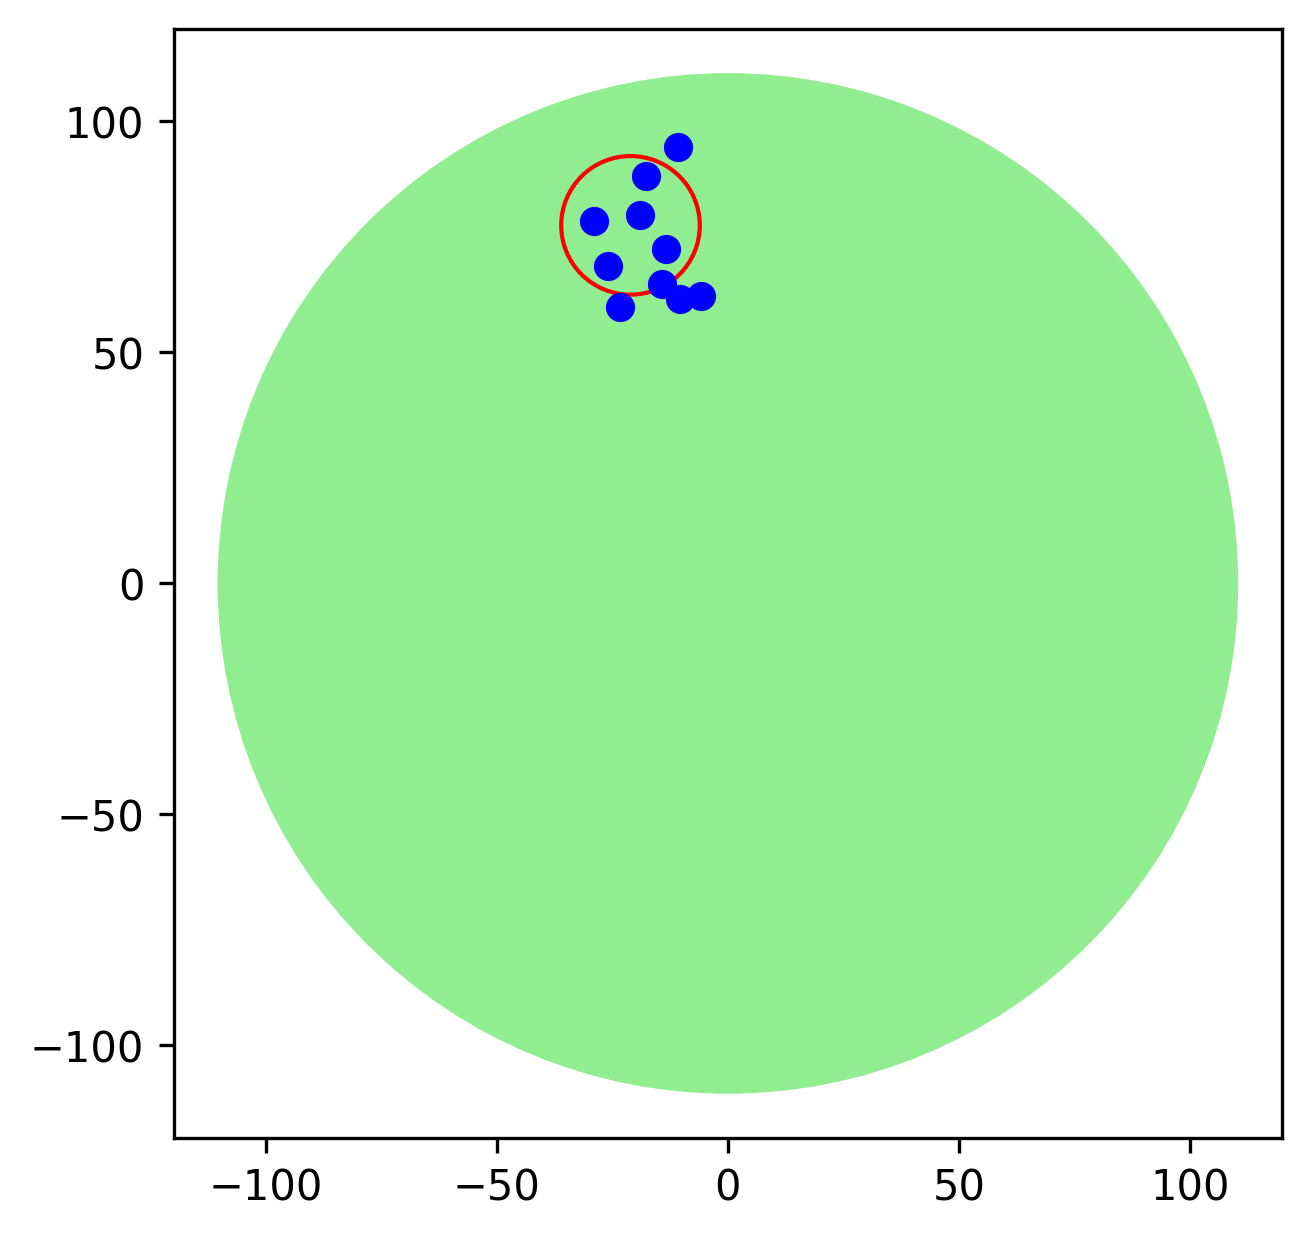

Cluster:  -21.092200647410056 77.50419178079449  Len:  5
Confidence: 0
Kalman:  [-21.09220065  77.50419178   0.           0.        ]
Weighted:  (-21.092200647410056, 77.50419178079449, 0, 0)



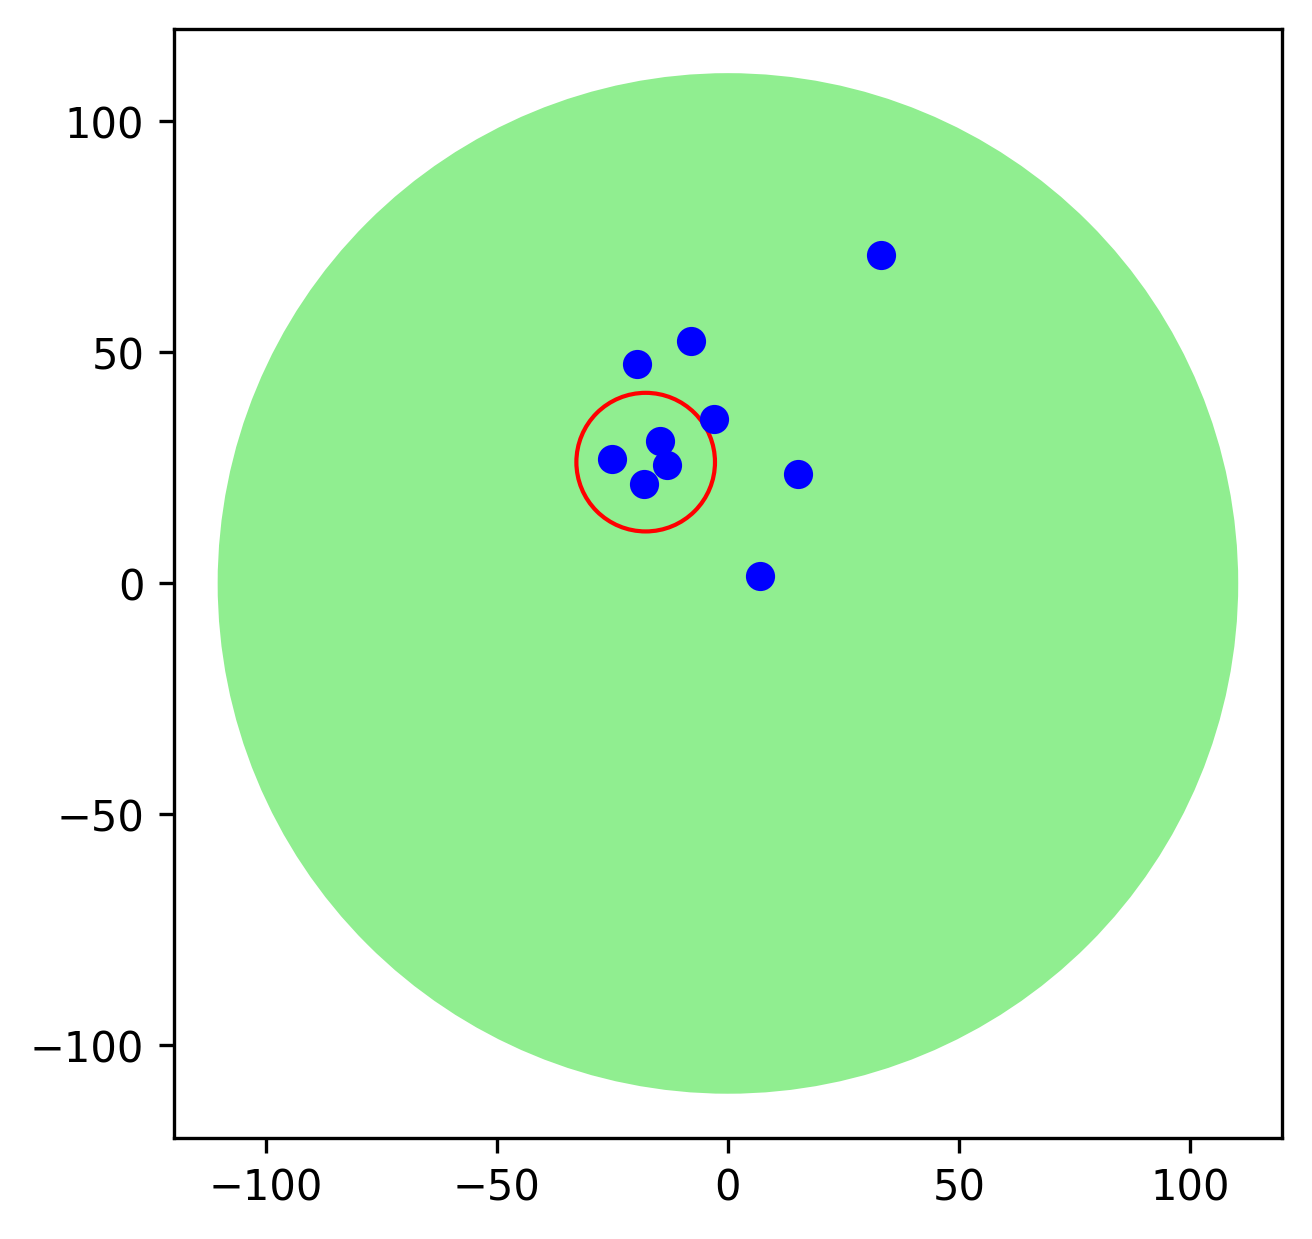

Cluster:  -17.805579514087377 26.255157787974124  Len:  4
Confidence: 0.25071745190759187
Kalman:  [-20.17554747  63.21060947   0.36212014  -5.64662208]
Weighted:  (-17.805579514087377, 26.255157787974127, 10.8625256419998, -169.38184332549733)



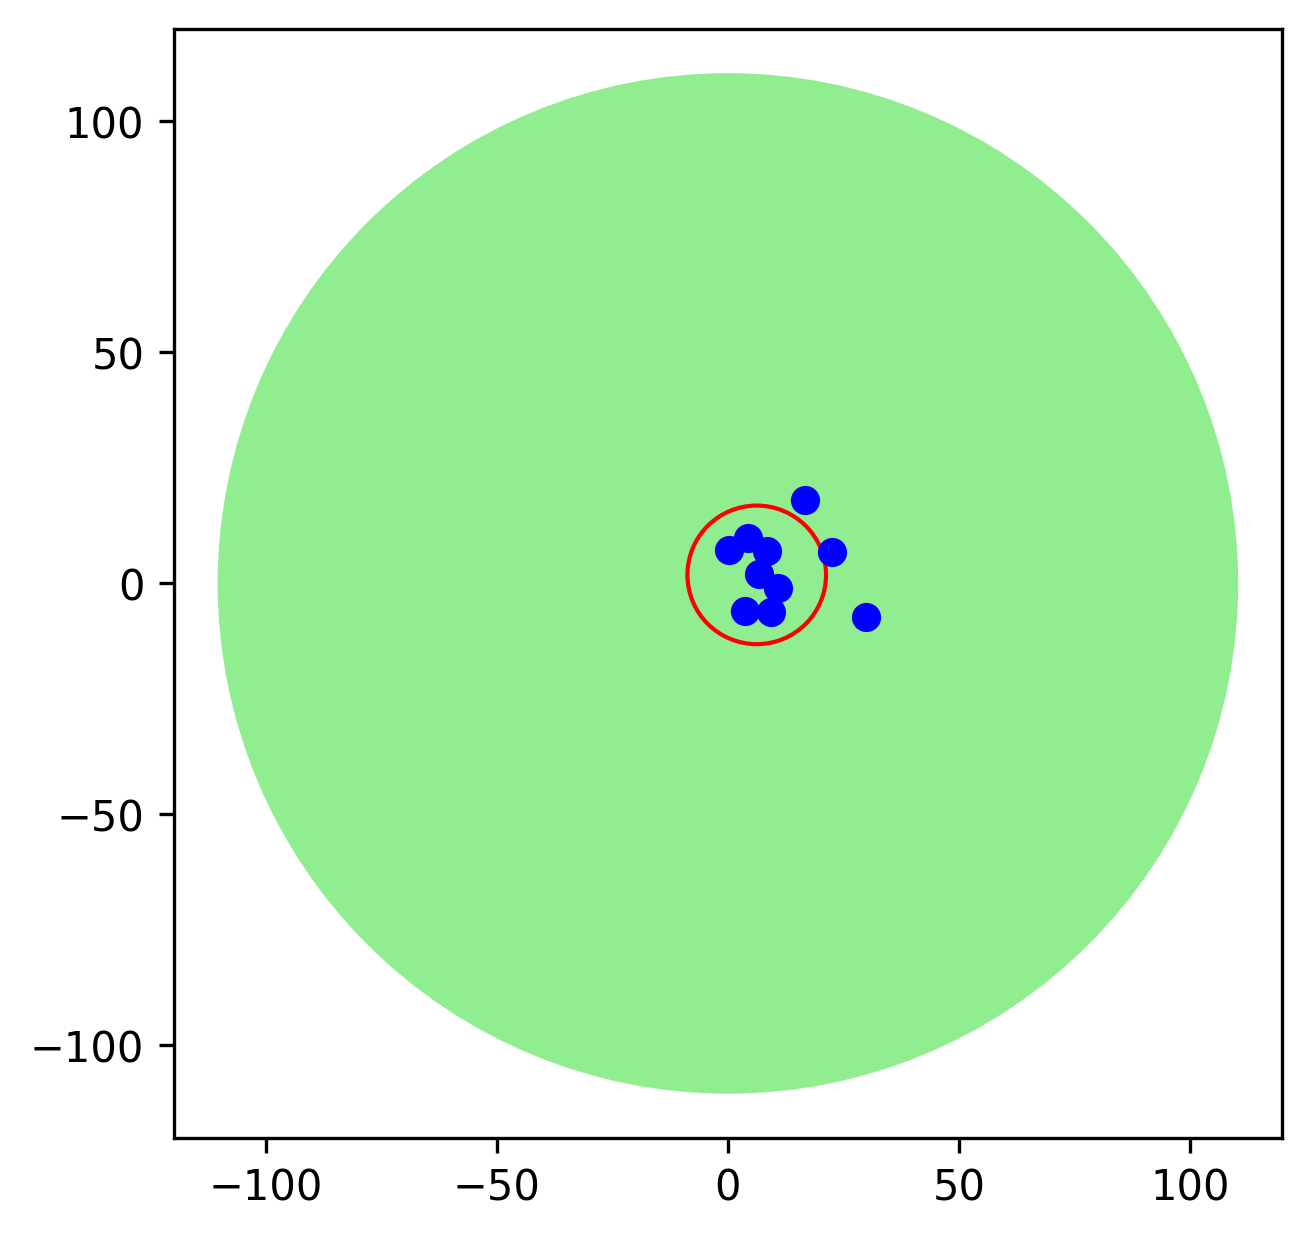

Cluster:  6.233120877993099 1.8522670560254484  Len:  7
Confidence: 0.07489102756047727
Kalman:  [-12.01288112  42.97183152   5.80601063 -17.91508536]
Weighted:  (-2.968847920577602, -16.756026182039612, 36.93036970121396, -116.66724529150332)



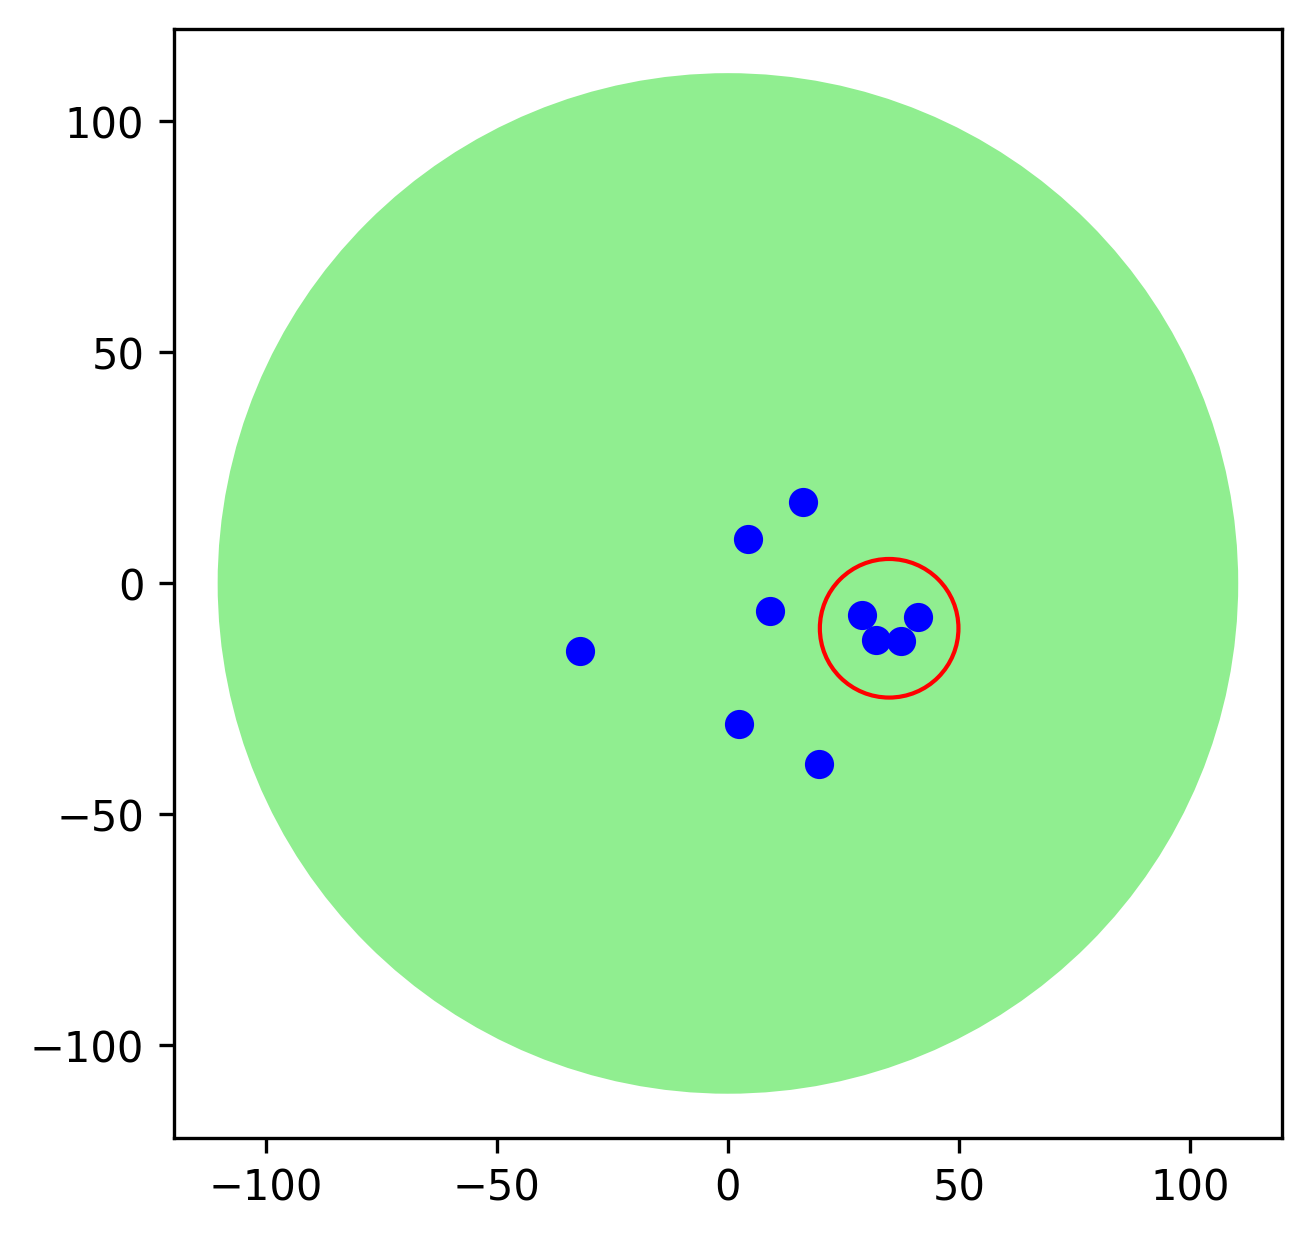

Cluster:  34.89289304083233 -9.704659994357518  Len:  4
Confidence: 0.27964325656805444
Kalman:  [  4.07219953  22.65645318  16.09153118 -28.7146767 ]
Weighted:  (20.173104826488107, -32.72858546127058, 60.11509967697131, -85.92609349482701)



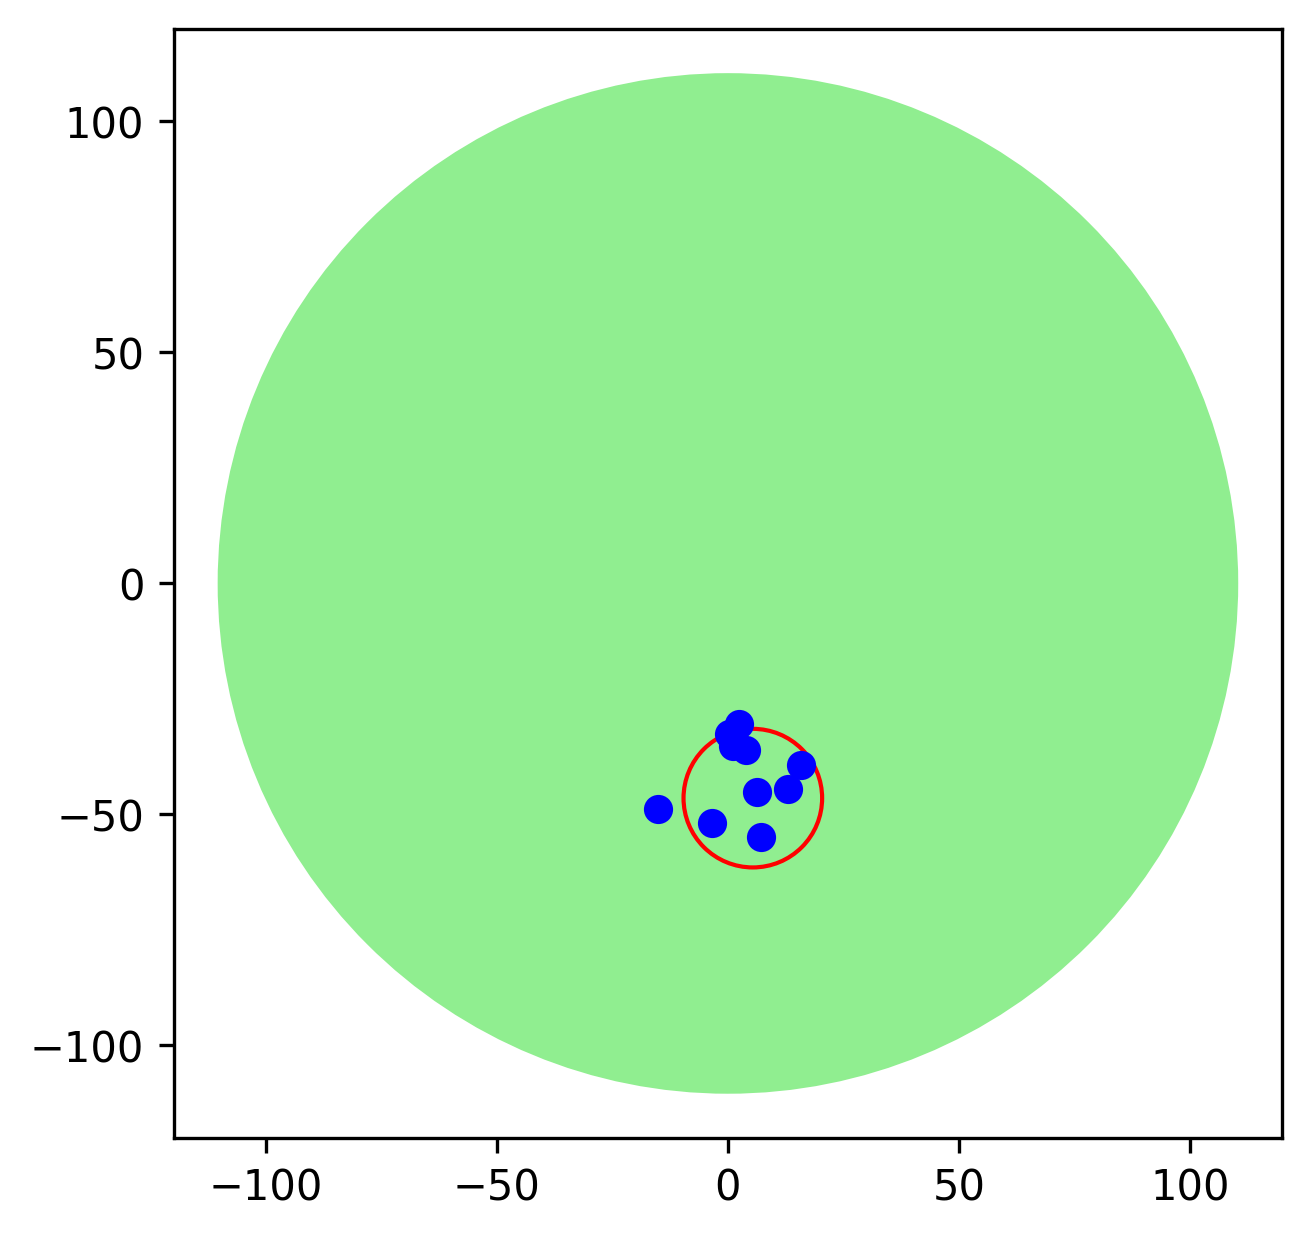

Cluster:  5.387398050382883 -46.47195400701962  Len:  5
Confidence: 0
Kalman:  [  7.66007485  -5.62666805  15.33229089 -42.35998991]
Weighted:  (25.92861439539758, -60.762262010091504, 19.724705365069383, -96.07420569885689)



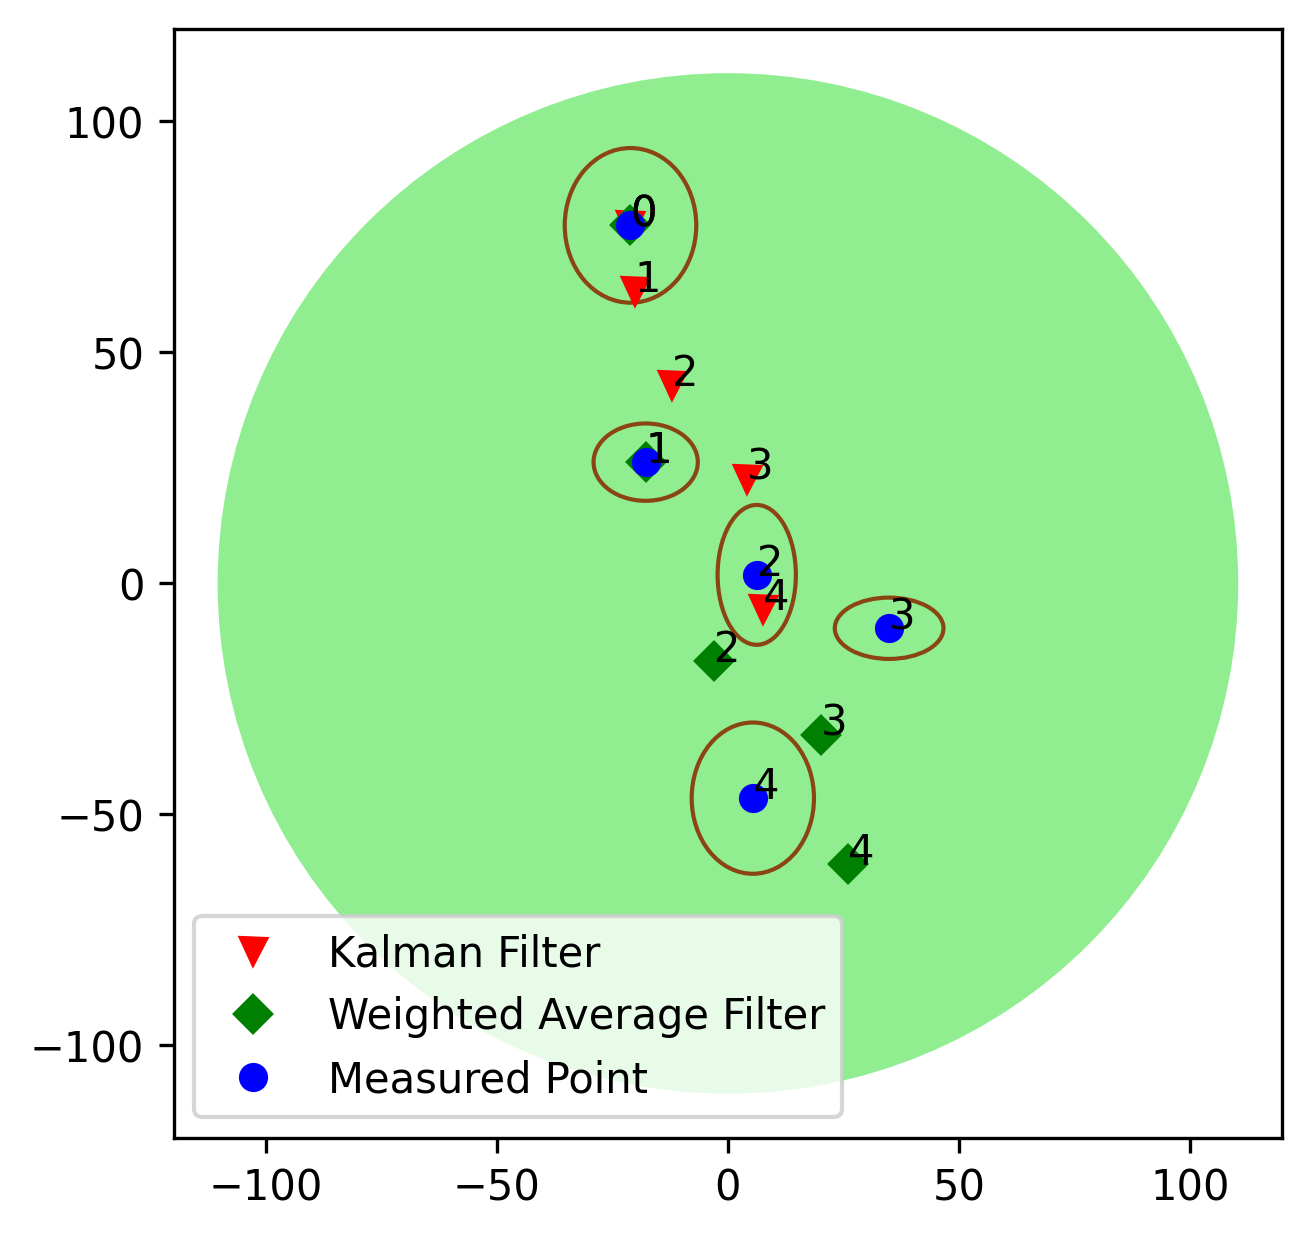

In [79]:
from IPython.display import clear_output
import time
ser.flushInput()
clear_output(wait=True)
clustering_threshold = 15
max_std = clustering_threshold / 2
last_measurement_time = None
initialized = False
data = []
for _ in range(5):
    time_data = ser.readline()
    time_data = time_data.decode('utf-8')
    time_data = time_data.split(',')
    # remove trailing \n on last element
    time_data[-1] = time_data[-1].strip()
    time_data = [int(x) for x in time_data]
    coupled_measurements = [[radius_mm*np.cos(-i*2*np.pi/5), radius_mm*np.sin(-i*2*np.pi/5), time_data[i]] for i in range(len(time_data))]
    # print("Iteration ", i)
    # print("Measurments ", coupled_measurements)
    pos_x, pos_y, std_dev = solve_best_fit(coupled_measurements, clustering_threshold)
    if (pos_x is not None):
        confidence_score = 1 - (np.linalg.norm(std_dev) / max_std)
        confidence_score = min(max(confidence_score, 0), 1)
        current_time = time.time()
        dt = (current_time - last_measurement_time) if last_measurement_time is not None else 0
        kal_ret, _ = kalman_filter(pos_x, pos_y, not initialized, dt=dt)
        weight_ret = weighted_avg_filter((pos_x, pos_y), not initialized, current_time, confidence_score)
        last_measurement_time = current_time
        initialized = True
        data.append([(pos_x, pos_y, std_dev), kal_ret, weight_ret])
        print("Confidence:", confidence_score)
        print("Kalman: ", kal_ret.reshape(-1))
        print("Weighted: ", weight_ret)
        print("")

viz(data)

In [80]:
ser.close()